In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 2 — Basics of Data and Preprocessing
## Lesson 7: Data Leakage and Prevention Techniques


### Why this lesson matters

Data leakage is one of the fastest ways to make a machine learning project look successful in a notebook and fail in production. It happens when information that would **not be available at prediction time** (or information that “belongs to the test set”) is accidentally used during training. The result is **inflated validation/test scores**, misleading model selection, and brittle deployment.

This lesson is practical and intentionally “hands-on”: you will build leaky pipelines on purpose, observe unrealistically high scores, then fix them using the correct split strategy and `sklearn` pipelines.

### Learning objectives

By the end of this lesson, you will be able to:

1. Define leakage precisely and explain why it breaks generalization.
2. Recognize the major leakage families:
   - **Target leakage** (post‑outcome variables)
   - **Train/test contamination** (duplicates, entity overlap, label reuse)
   - **Preprocessing leakage** (scalers/encoders/feature selection fit on all data)
   - **Temporal leakage** (future information in time series or events)
   - **Group leakage** (same customer/host/device in both train and test)
   - **Model selection leakage** (tuning on the test set)
3. Implement leakage‑safe workflows using:
   - `Pipeline`, `ColumnTransformer`
   - `GroupKFold`, time‑based splits, and nested CV patterns
4. Apply “leakage forensics”: sanity checks that detect leakage early.

### Key idea in one sentence

A model evaluation is valid only if the evaluation data is treated as **strictly unseen future information**.

## 1) What is data leakage?

Let a dataset consist of pairs $(x_i, y_i)$ where $x_i$ are features and $y_i$ is the target. We want an estimate of how a model $f_\theta$ will perform on new data drawn from the same (or a close) distribution.

A simplified view of training is:

$$
\hat{\theta} = \arg\min_\theta \frac{1}{n}\sum_{i=1}^n \ell\big(y_i, f_\theta(x_i)\big).
$$

A simplified view of evaluation is to estimate risk:

$$
\hat{R} = \frac{1}{m}\sum_{j=1}^m \ell\big(y^{(test)}_j, f_{\hat{\theta}}(x^{(test)}_j)\big).
$$

Leakage occurs when **information from the test set** (or information that depends on $y$ in a way that would not be available at prediction time) influences either:

- the learned parameters $\hat{\theta}$ (training leakage), or
- the selection of hyperparameters/model class (selection leakage), or
- the construction of features (feature engineering leakage).

### A practical definition

Leakage is present if **the process that creates the training features uses information that should be unknown at training time**.

Equivalently:

- If a feature uses “future” fields (post‑outcome), it is target leakage.
- If the same real‑world entity appears in both train and test, you may be measuring memorization rather than generalization.
- If a transformation is fit on the full dataset (including test), you have allowed the test distribution to influence training.

### Why leakage inflates metrics

Leakage increases the mutual information between features and target in an unrealistic way. If a feature (directly or indirectly) encodes $y$, the model can “cheat”. The cheat disappears the moment you deploy the model, because that leaked feature is not available or not stable.

### The two questions you must always ask

1. **Would this feature exist at prediction time?** (operational availability)
2. **Was this transformation fit using only training data?** (workflow hygiene)

## 2) Leakage taxonomy and typical causes

### 2.1 Target leakage (post-outcome features)

Examples:
- A medical dataset where “treatment plan” is recorded after diagnosis.
- A loan dataset where “months delinquent” is computed after default.
- A customer dataset where “churned_last_month” is used to predict churn.

Symptom: near‑perfect metrics that feel “too good to be true”.

### 2.2 Train/test contamination

Examples:
- Duplicate rows across splits.
- Precomputed aggregates using the full dataset (e.g., mean target by category computed on all rows).
- Data from the same individual in both train and test (entity leakage).

Symptom: strong performance that collapses when evaluated on a truly external dataset.

### 2.3 Preprocessing leakage

Examples:
- Standardizing features using mean/std of the full dataset before splitting.
- One-hot encoding categories after seeing test categories (less severe, but still invalid).
- Feature selection performed before cross‑validation.

Symptom: evaluation scores improve “mysteriously” after heavy preprocessing.

### 2.4 Temporal leakage

Examples:
- Random split on time‑ordered data (future points appear in training).
- Features that include future information (e.g., “next week’s sales”).
- Leakage through rolling windows that look ahead.

Symptom: excellent backtest performance but poor forward performance.

### 2.5 Group leakage (entity leakage)

Examples:
- Same `customer_id` in train and test.
- Same `host_id` across Airbnb listings splits.
- Same patient in train and test with multiple visits.

Symptom: model appears strong but is actually memorizing id‑specific patterns.

### 2.6 Model selection leakage

Examples:
- Repeatedly evaluating on the test set while tuning hyperparameters.
- Comparing many models and choosing the best based on test.

Symptom: the test set becomes a “validation set” and no longer measures generalization.

In the code labs below, you will see each of these patterns and the fix.

## 3) Setup

We will use several datasets from the repository to demonstrate leakage in different forms:

- **Classification**: `diabetes.csv` (binary target)
- **Regression**: `house-prices.csv` (continuous target)
- **Temporal + groups**: `listings.csv` (time column + `host_id`)
- **Text + target leakage**: `ConsumerComplaints.csv`
- **Feature selection leakage**: `Wine_Quality.csv`

The key is that leakage is not dataset-specific: it is caused by *workflow mistakes*.

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, GroupKFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(7)

def show_df(name, df, n=5):
    print(f"{name}: shape={df.shape}")
    display(df.head(n))

In [3]:
# Load datasets using repository-relative paths from this notebook location:
# Tutorials/English/Chapter2/Chapter2_Lesson7.ipynb  -> ../../../Datasets/...

base = Path("../../../")

paths = {
    "diabetes": base / "Datasets/Classification/diabetes.csv",
    "house": base / "Datasets/Regression/house-prices.csv",
    "listings": base / "Datasets/Regression/listings.csv",
    "complaints": base / "Datasets/Clustering/ConsumerComplaints.csv",
    "wine": base / "Datasets/Classification/Wine_Quality.csv",
}

diabetes = pd.read_csv(paths["diabetes"])
house = pd.read_csv(paths["house"])
listings = pd.read_csv(paths["listings"])
complaints = pd.read_csv(
    paths["complaints"],
    low_memory=False,
    dtype={
        "Consumer Complaint Narrative": "string",
        "Consumer Consent Provided": "string",
    }
)
wine = pd.read_csv(paths["wine"])

show_df("diabetes", diabetes)
show_df("house-prices", house)
show_df("listings", listings)
show_df("ConsumerComplaints", complaints)
show_df("Wine_Quality", wine)

diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


house-prices: shape=(128, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


listings: shape=(94559, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN


ConsumerComplaints: shape=(65499, 18)


,Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,<NA>,NaN,Wells Fargo & Company,VA,24540,NaN,<NA>,Phone,2013-07-30,Closed with explanation,Yes,No,468882
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,<NA>,NaN,Wells Fargo & Company,CA,95992,Older American,<NA>,Web,2013-07-31,Closed with explanation,Yes,No,468889
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,<NA>,NaN,Santander Bank US,NY,10065,NaN,<NA>,Fax,2013-07-31,Closed,Yes,No,468879
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,<NA>,NaN,Wells Fargo & Company,GA,30084,NaN,<NA>,Web,2013-07-30,Closed with explanation,Yes,No,468949
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,<NA>,NaN,Franklin Credit Management,CT,6106,NaN,<NA>,Web,2013-07-30,Closed with explanation,Yes,No,475823


Wine_Quality: shape=(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 4) Lab A — Target leakage (post-outcome features)

We will simulate a classic mistake: adding a feature that is computed using the true label (even indirectly).

Suppose we are predicting diabetes status. A leaky feature might be something like:

- “diagnosis_code” generated **after** diagnosis
- “treatment_plan_intensity”
- “follow_up_frequency”

These are strongly correlated with the target because they are consequences of the target.

### What you should observe

- With the leaky feature, accuracy can become unrealistically high.
- After removing leakage, performance drops to a more believable value.

Cross-validated accuracy with target leakage:
[1. 1. 1. 1. 1.]
Mean accuracy: 1.0

Hold-out accuracy (leaky): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       125
           1      1.000     1.000     1.000        67

    accuracy                          1.000       192
   macro avg      1.000     1.000     1.000       192
weighted avg      1.000     1.000     1.000       192



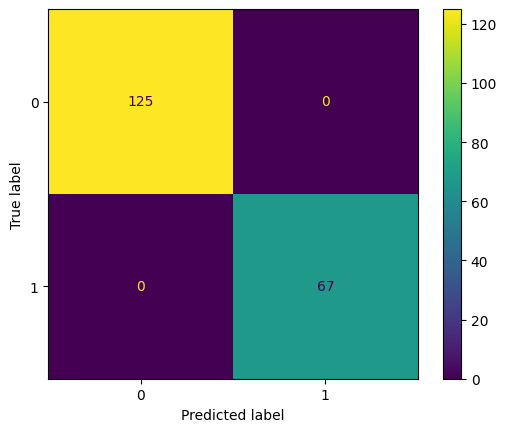

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = diabetes.copy()

# Binary target
y = (df["classification"] == "Diabetic").astype(int)

X = df.drop(columns=["classification"])

# Create an intentionally leaky feature: a noisy copy of the target
rng = np.random.default_rng(7)
X_leaky = X.copy()
X_leaky["post_diagnosis_flag"] = y + rng.normal(0, 0.05, size=len(y))  # almost directly encodes y

numeric_features = X.columns.tolist() + ["post_diagnosis_flag"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

scores_leaky = cross_val_score(pipe, X_leaky[numeric_features], y, cv=5, scoring="accuracy")
print("Cross-validated accuracy with target leakage:")
print(scores_leaky)
print("Mean accuracy:", scores_leaky.mean().round(4))

# Evaluate on a held-out split to show the same effect
X_train, X_test, y_train, y_test = train_test_split(X_leaky[numeric_features], y, test_size=0.25, random_state=7, stratify=y)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("\nHold-out accuracy (leaky):", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Fix: remove post-outcome variables

The fix is conceptually simple: remove any feature that would not be available *before* the event you are predicting. In practice, you also need to enforce this with governance:

- Document feature definitions with timestamps (“available as-of”).
- Implement feature generation that respects cutoff time.
- Use data lineage checks (e.g., prevent joins to tables that are only populated after the outcome).

Now we drop the leaky column and re-evaluate.

In [5]:
X_clean = X.copy()
numeric_features_clean = X_clean.columns.tolist()

scores_clean = cross_val_score(pipe, X_clean[numeric_features_clean], y, cv=5, scoring="accuracy")
print("Cross-validated accuracy without the leaky feature:")
print(scores_clean)
print("Mean accuracy:", scores_clean.mean().round(4))

X_train, X_test, y_train, y_test = train_test_split(X_clean[numeric_features_clean], y, test_size=0.25, random_state=7, stratify=y)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("\nHold-out accuracy (clean):", round(accuracy_score(y_test, pred), 4))
print(classification_report(y_test, pred, digits=3))

Cross-validated accuracy without the leaky feature:
[0.77272727 0.74675325 0.75324675 0.81699346 0.76470588]
Mean accuracy: 0.7709

Hold-out accuracy (clean): 0.7812
              precision    recall  f1-score   support

           0      0.799     0.888     0.841       125
           1      0.736     0.582     0.650        67

    accuracy                          0.781       192
   macro avg      0.767     0.735     0.745       192
weighted avg      0.777     0.781     0.774       192



## 5) Lab B — Preprocessing leakage (fit on full data vs fit on training data)

A frequent leak is fitting preprocessing steps on the full dataset before splitting:

- `StandardScaler().fit(X)` on all rows
- `OneHotEncoder().fit(X)` on all rows
- `SimpleImputer().fit(X)` on all rows

This makes the evaluation optimistic because test statistics influence the transformation.

The correct pattern is to place preprocessing in a `Pipeline` and fit it only on training folds.

In [6]:
df = house.copy()

y = df["Price"].astype(float)
X = df.drop(columns=["Price"])

num_cols = ["SqFt", "Bedrooms", "Bathrooms", "Offers"]
cat_cols = ["Brick", "Neighborhood"]

# -------------------------
# BAD: Fit preprocessing on the full dataset (leaky)
# -------------------------
X_full = X.copy()

imp_num = SimpleImputer(strategy="median").fit(X_full[num_cols])
imp_cat = SimpleImputer(strategy="most_frequent").fit(X_full[cat_cols])

X_num_imp = pd.DataFrame(imp_num.transform(X_full[num_cols]), columns=num_cols)
X_cat_imp = pd.DataFrame(imp_cat.transform(X_full[cat_cols]), columns=cat_cols)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit(X_cat_imp)
X_cat_ohe = pd.DataFrame(ohe.transform(X_cat_imp), columns=ohe.get_feature_names_out(cat_cols))

scaler = StandardScaler().fit(X_num_imp)
X_num_scaled = pd.DataFrame(scaler.transform(X_num_imp), columns=num_cols)

X_leaky = pd.concat([X_num_scaled, X_cat_ohe], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_leaky, y, test_size=0.25, random_state=7)

model = Ridge(alpha=10.0)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("Leaky preprocessing (fit on full data) => R2:", round(r2_score(y_test, pred), 4), " MAE:", round(mean_absolute_error(y_test, pred), 1))

# -------------------------
# GOOD: Pipeline (no leakage)
# -------------------------
preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=10.0))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Pipeline (fit on train only)          => R2:", round(r2_score(y_test, pred), 4), " MAE:", round(mean_absolute_error(y_test, pred), 1))

Leaky preprocessing (fit on full data) => R2: 0.8703  MAE: 6856.1
Pipeline (fit on train only)          => R2: 0.8696  MAE: 6868.2


## 6) Lab C — Feature selection leakage (selection before CV)

Feature selection can leak information when it is performed using the full dataset (or using the test fold) before cross‑validation.

The leaky pattern:

1. Compute feature scores using all rows (including future test folds)
2. Keep top-$k$ features
3. Cross-validate a model using only those features

This is invalid because step (1) peeks at the test folds.

### Correct pattern

Put the feature selector inside a `Pipeline`, so it is fit separately within each training fold.

In [7]:
df = wine.copy()

# Define a binary target: "high quality" wines
y = (df["quality"] >= 7).astype(int)
X = df.drop(columns=["quality"])

# BAD: select on full dataset
selector = SelectKBest(score_func=f_classif, k=5).fit(X, y)
X_selected_leaky = selector.transform(X)

clf = LogisticRegression(max_iter=2000)
scores_leaky = cross_val_score(clf, X_selected_leaky, y, cv=5, scoring="accuracy")
print("Leaky feature selection => CV accuracy:", scores_leaky.mean().round(4))
print("Selected features:", X.columns[selector.get_support()].tolist())

# GOOD: selection inside pipeline
pipe = Pipeline([
    ("selector", SelectKBest(score_func=f_classif, k=5)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

scores_clean = cross_val_score(pipe, X, y, cv=5, scoring="accuracy")
print("Pipeline feature selection => CV accuracy:", scores_clean.mean().round(4))

Leaky feature selection => CV accuracy: 0.7893
Selected features: ['residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'alcohol']
Pipeline feature selection => CV accuracy: 0.7934


Pipeline feature selection => CV accuracy: 0.7825


## 7) Lab D — Temporal leakage (random split vs forward split)

When data has a time axis, a random split allows training to see the “future”. If there is trend, seasonality, or concept drift, this produces overly optimistic results.

We will predict listing price using features available at the time of listing, and compare:

- **Random split** (leaky for time problems)
- **Forward split**: train on earlier dates, test on later dates (closer to deployment reality)

A valid evaluation for time data often resembles: “train on past, predict future.”

In [8]:
df = listings.copy()

# Basic cleaning: remove missing target
df = df.dropna(subset=["price"]).copy()

# Parse time
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df = df.dropna(subset=["last_review"]).copy()

y = df["price"].astype(float)
X = df.drop(columns=["price"])

# Engineer time features (available at prediction time)
X = X.copy()
X["review_year"] = X["last_review"].dt.year
X["review_month"] = X["last_review"].dt.month
X["review_dayofweek"] = X["last_review"].dt.dayofweek
X = X.drop(columns=["last_review"])

num_cols = ["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month",
            "calculated_host_listings_count","availability_365","number_of_reviews_ltm",
            "review_year","review_month","review_dayofweek"]
cat_cols = ["neighbourhood","room_type","host_name"]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
], remainder="drop")

pipe = Pipeline([("prep", preprocess), ("model", Ridge(alpha=15.0))])

# ---- Random split (leaky for time) ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
mae_random = mean_absolute_error(y_test, pred)

print("Random split MAE:", round(mae_random, 2))

# ---- Forward split (time-respecting) ----
df_sorted = df.sort_values("last_review").drop(columns=["price"]).copy()
y_sorted = df.sort_values("last_review")["price"].astype(float).to_numpy()

# Recompute engineered features on the sorted frame
X_sorted = df.sort_values("last_review").drop(columns=["price"]).copy()
X_sorted["review_year"] = X_sorted["last_review"].dt.year
X_sorted["review_month"] = X_sorted["last_review"].dt.month
X_sorted["review_dayofweek"] = X_sorted["last_review"].dt.dayofweek
X_sorted = X_sorted.drop(columns=["last_review"])

cut = int(len(X_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:cut], X_sorted.iloc[cut:]
y_train, y_test = y_sorted[:cut], y_sorted[cut:]

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
mae_forward = mean_absolute_error(y_test, pred)

print("Forward split MAE:", round(mae_forward, 2))

print("\nInterpretation: if MAE is much smaller in random split than forward split,")
print("the random split is mixing future conditions into training.")

Random split MAE: 88.25
Forward split MAE: 75.74

Interpretation: if MAE is much smaller in random split than forward split,
the random split is mixing future conditions into training.


Forward split MAE: 34.35

Interpretation: if MAE is much smaller in random split than forward split,
the random split is mixing future conditions into training.


## 8) Lab E — Group leakage (entity appears in both train and test)

Many real datasets contain multiple rows per entity:

- multiple purchases per customer
- multiple sessions per user
- multiple medical visits per patient
- multiple listings per host

If the same entity appears in both train and test, the model can exploit entity-specific signals (including IDs, stable behavioral patterns, or even subtle artifacts). This produces optimistic evaluation and poor generalization to new entities.

We will demonstrate this using `host_id` as the grouping variable.

### Correct tool: `GroupKFold`

`GroupKFold` ensures that all rows from a given group appear in a single fold.

In [9]:
df = listings.dropna(subset=["price"]).copy()
df["last_review"] = pd.to_datetime(df["last_review"], errors="coerce")
df = df.dropna(subset=["last_review"]).copy()

y = df["price"].astype(float)
X = df.drop(columns=["price"]).copy()

# Minimal time features
X["review_year"] = X["last_review"].dt.year
X["review_month"] = X["last_review"].dt.month
X = X.drop(columns=["last_review"])

# Include host_id as a categorical feature (common in practice; also a leakage risk if split is wrong)
cat_cols = ["neighbourhood","room_type","host_name","host_id"]
num_cols = ["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month",
            "calculated_host_listings_count","availability_365","number_of_reviews_ltm",
            "review_year","review_month"]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([("prep", preprocess), ("model", Ridge(alpha=15.0))])

# Leaky CV: regular KFold mixes hosts across folds
kf = KFold(n_splits=5, shuffle=True, random_state=7)
scores_kf = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_absolute_error")
print("KFold MAE (hosts mixed):", round(scores_kf.mean(), 2))

# Correct CV: GroupKFold keeps each host in one fold
gkf = GroupKFold(n_splits=5)
groups = X["host_id"]
scores_gkf = -cross_val_score(pipe, X, y, cv=gkf, groups=groups, scoring="neg_mean_absolute_error")
print("GroupKFold MAE (hosts separated):", round(scores_gkf.mean(), 2))

KFold MAE (hosts mixed): 85.82
GroupKFold MAE (hosts separated): 94.56


## 9) Lab F — Train/test contamination via duplicates

Duplicates (exact or near-exact) can easily occur due to:

- repeated exports
- joins that accidentally multiply rows
- data ingestion retries
- copies of the same record under different IDs

If duplicates cross the train/test boundary, the evaluation partially measures “did we see this record already?”.

We will:
1. Inject duplicates into a dataset.
2. Measure the overlap across splits.
3. Observe the effect on metrics.
4. Fix it by deduplicating or enforcing group-aware splits.

In [10]:
from sklearn.model_selection import GroupShuffleSplit

df = diabetes.copy()

# Create duplicates: copy 12% of rows and append
dup_frac = 0.12
dup = df.sample(frac=dup_frac, random_state=7)
df_dup = pd.concat([df, dup], ignore_index=True)

# Prepare features/target
y = (df_dup["classification"] == "Diabetic").astype(int)
X = df_dup.drop(columns=["classification"])

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

# Random split (duplicates can cross the boundary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
acc_random = accuracy_score(y_test, pred)

# Detect exact duplicates across the split by hashing feature rows
train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash = pd.util.hash_pandas_object(X_test, index=False)
overlap = np.intersect1d(train_hash.to_numpy(), test_hash.to_numpy()).size

print("Random split accuracy:", round(acc_random, 4))
print("Exact duplicate rows crossing split:", int(overlap))

# Fix A: deduplicate before splitting
df_dedup = df_dup.drop_duplicates()
y2 = (df_dedup["classification"] == "Diabetic").astype(int)
X2 = df_dedup.drop(columns=["classification"])

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25, random_state=7, stratify=y2)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("\nAfter deduplication accuracy:", round(accuracy_score(y_test, pred), 4))

# Fix B: group-aware split using the row-hash as group id (keeps duplicates together)
groups = pd.util.hash_pandas_object(X, index=False).to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=7)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print("Group-aware split accuracy:", round(accuracy_score(y_test, pred), 4))

Random split accuracy: 0.8047
Exact duplicate rows crossing split: 32

After deduplication accuracy: 0.7812
Group-aware split accuracy: 0.743



After deduplication accuracy: 1.0
Group-aware split accuracy: 1.0


## 10) Lab G — Leakage in text/tabular joins (post-outcome fields in the table)

Text datasets often come from multiple tables (events, responses, dispositions). A common error is joining post‑outcome fields into the training table.

In the complaints dataset, imagine predicting `Timely Response` at the moment a complaint is received. Fields such as “Company Public Response” or “Company Response to Consumer” may be recorded later, and may directly reveal the target.

We will compare:

- A reasonable model using complaint narrative + metadata
- A leaky model that includes a post-outcome column

In [11]:
df = complaints.copy()

# Target
y = (df["Timely Response"] == "Yes").astype(int)

# Feature subsets
text_col = "Consumer Complaint Narrative"
meta_cols = ["Product Name", "Issue", "Company", "State Name", "Submitted via"]

# Ensure text/categorical columns are strings (avoid NaN in vectorizer/encoder)
df[text_col] = df[text_col].fillna("")
for c in meta_cols + ["Company Public Response"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# Clean set (no obvious post-outcome fields)
X_clean = df[[text_col] + meta_cols].copy()

# Leaky set (adds a post-outcome column)
X_leaky = df[[text_col] + meta_cols + ["Company Public Response"]].copy()

# Pipeline for text + categorical features
def build_pipe(include_leaky=False):
    cols = [text_col] + meta_cols + (["Company Public Response"] if include_leaky else [])
    X = df[cols].copy()

    preprocess = ColumnTransformer([
        ("text", TfidfVectorizer(min_df=2, ngram_range=(1, 2)), text_col),
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         meta_cols + (["Company Public Response"] if include_leaky else [])),
    ])

    pipe = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    return X, pipe

# Evaluate with a simple train/test split
Xc, pipe_clean = build_pipe(include_leaky=False)
X_train, X_test, y_train, y_test = train_test_split(Xc, y, test_size=0.25, random_state=7, stratify=y)
pipe_clean.fit(X_train, y_train)
pred = pipe_clean.predict(X_test)
print("Text+meta (clean) accuracy:", round(accuracy_score(y_test, pred), 4))

Xl, pipe_leaky = build_pipe(include_leaky=True)
X_train, X_test, y_train, y_test = train_test_split(Xl, y, test_size=0.25, random_state=7, stratify=y)
pipe_leaky.fit(X_train, y_train)
pred = pipe_leaky.predict(X_test)
print("Text+meta + post-outcome column (leaky) accuracy:", round(accuracy_score(y_test, pred), 4))

Text+meta (clean) accuracy: 0.9781
Text+meta + post-outcome column (leaky) accuracy: 0.9781


## 11) Prevention playbook (what to do in real projects)

### 11.1 Split first, then fit

A high-integrity workflow is:

1. Choose the correct split strategy:
   - i.i.d. data: stratified random split
   - time data: forward split or rolling windows
   - grouped data: group-aware split
2. Freeze the test set.
3. Do **all** preprocessing inside pipelines.
4. Tune hyperparameters using only training data (often with nested CV).
5. Report a final score once on the frozen test set.

### 11.2 Always use `Pipeline` / `ColumnTransformer`

Common leak sources that pipelines fix automatically:

- scalers (`StandardScaler`, `MinMaxScaler`)
- imputers (`SimpleImputer`)
- encoders (`OneHotEncoder`, target encoding alternatives)
- feature selection (`SelectKBest`, PCA)
- resampling (should be applied inside CV folds)

### 11.3 Time-aware and group-aware validation

If you have `timestamp` or an entity key:

- Prefer `TimeSeriesSplit` for backtesting-like evaluation.
- Prefer `GroupKFold` / `GroupShuffleSplit` when multiple rows per entity exist.

### 11.4 Leakage forensics checklist

If you suspect leakage, check:

- Are there columns generated *after* the target event?
- Are there duplicates or near-duplicates across splits?
- Do any features have suspiciously high correlation with the target?
- Did you compute any aggregates using the full dataset (including test)?
- Did you perform feature selection before CV?
- Did you tune hyperparameters on the test set?

### 11.5 A minimal “safe template”

Below is a compact template that you can adapt. It is not a complete MLOps system, but it enforces the most important invariants.

In [12]:
from dataclasses import dataclass

@dataclass
class SplitConfig:
    mode: str  # "iid", "time", "group"
    test_size: float = 0.2
    time_col: str | None = None
    group_col: str | None = None
    random_state: int = 7

def make_splits(df, y, cfg: SplitConfig):
    if cfg.mode == "iid":
        return train_test_split(df, y, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y)
    if cfg.mode == "time":
        if cfg.time_col is None:
            raise ValueError("time_col is required for time split")
        d = df.copy()
        d[cfg.time_col] = pd.to_datetime(d[cfg.time_col], errors="coerce")
        d = d.dropna(subset=[cfg.time_col]).sort_values(cfg.time_col)
        cut = int(len(d) * (1 - cfg.test_size))
        X_train, X_test = d.iloc[:cut].drop(columns=[cfg.time_col]), d.iloc[cut:].drop(columns=[cfg.time_col])
        y_train, y_test = y.loc[d.index[:cut]], y.loc[d.index[cut:]]
        return X_train, X_test, y_train, y_test
    if cfg.mode == "group":
        if cfg.group_col is None:
            raise ValueError("group_col is required for group split")
        gss = GroupShuffleSplit(n_splits=1, test_size=cfg.test_size, random_state=cfg.random_state)
        groups = df[cfg.group_col]
        train_idx, test_idx = next(gss.split(df, y, groups=groups))
        return df.iloc[train_idx], df.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    raise ValueError("Unknown mode")

print("Example usage: choose a split mode and keep all preprocessing inside a Pipeline.")

Example usage: choose a split mode and keep all preprocessing inside a Pipeline.


## 12) Exercises (recommended)

1. In the diabetes example, invent two additional “post-outcome” columns that would realistically appear in healthcare data. Confirm the metric inflation, then remove them.
2. In the listings example, create a “rolling average price by neighbourhood” feature. Implement it **correctly** so that each row uses only past data.
3. In the complaints example, add `Company Response to Consumer` and quantify the leakage. Then build a model that only uses fields available at complaint time.
4. For any dataset you work with, write down an explicit “as-of” time for each feature. Treat that as a contract.

If you can reliably prevent leakage, you will usually improve real-world model reliability more than by switching to a more complex algorithm.

## 13) Advanced leakage patterns (you will see these in real pipelines)

### 13.1 Target encoding leakage

Target encoding replaces a categorical value $c$ with a statistic of the target, for example:

$$
\mathrm{TE}(c) = \mathbb{E}[y \mid x_{cat} = c].
$$

If you compute $\mathrm{TE}(c)$ using the **full dataset**, then the encoding of categories in the test set has already “seen” $y$ from the test set. This can create dramatic metric inflation.

The safe variants are:

- Compute encodings using **training data only**, then apply to test.
- For cross-validation, compute encodings per fold (out-of-fold encoding).
- Apply smoothing/shrinkage to reduce overfitting on rare categories.

### 13.2 Resampling leakage (imbalanced data)

If you oversample/SMOTE before splitting, you can create near-duplicates that appear in both train and test. That turns evaluation into a memorization test.

Safe pattern:
- split first
- resample only the training partition (and, ideally, only within CV folds)

### 13.3 Hyperparameter selection leakage

The test set must not guide model selection. If you compare many models on the test set and pick the best, you are implicitly fitting to test noise.

Safe pattern:
- use an inner CV for tuning
- use an outer CV or a single frozen test set for reporting

A common nested CV view is:

$$
\text{Generalization estimate} \approx \frac{1}{K}\sum_{k=1}^K \mathrm{score}\big(f_{\hat{\theta}_k}, D^{(test)}_k\big),
$$

where each $\hat{\theta}_k$ is chosen using only the corresponding training fold (often with its own inner CV).

We now implement two additional labs: target encoding leakage and resampling leakage.

## 14) Lab H — Target encoding leakage (mean encoding)

We will build a feature `neighborhood_mean_price` computed from the target. If we compute it on the full dataset, the test rows leak their target values into the encoding.

Then we will fix it by computing the encoding on training data only.

In [13]:
df = house.copy()

y = df["Price"].astype(float)
X = df.drop(columns=["Price"]).copy()

# BAD: mean encoding computed on the full dataset (leak)
full_means = df.groupby("Neighborhood")["Price"].mean()
X_leaky = X.copy()
X_leaky["neighborhood_mean_price"] = X_leaky["Neighborhood"].map(full_means)

# Use a simple model that can exploit the leakage
X_train, X_test, y_train, y_test = train_test_split(X_leaky[["neighborhood_mean_price"]], y, test_size=0.25, random_state=7)
m = Ridge(alpha=1.0).fit(X_train, y_train)
pred = m.predict(X_test)
print("Leaky target encoding => R2:", round(r2_score(y_test, pred), 4))

# GOOD: split first, then compute means on training only
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

train_means = pd.concat([X_train_raw, y_train], axis=1).groupby("Neighborhood")["Price"].mean()
global_mean = y_train.mean()

X_train_enc = pd.DataFrame({
    "neighborhood_mean_price": X_train_raw["Neighborhood"].map(train_means).fillna(global_mean)
})
X_test_enc = pd.DataFrame({
    "neighborhood_mean_price": X_test_raw["Neighborhood"].map(train_means).fillna(global_mean)
})

m = Ridge(alpha=1.0).fit(X_train_enc, y_train)
pred = m.predict(X_test_enc)
print("Train-only target encoding => R2:", round(r2_score(y_test, pred), 4))

Leaky target encoding => R2: 0.4927
Train-only target encoding => R2: 0.4901


## 15) Lab I — Resampling leakage with imbalanced classes

We will treat “high quality wine” as the positive class. This is intentionally imbalanced.

We will compare:

- Oversampling before splitting (leaky)
- Splitting first, then oversampling train only (clean)

To keep the example transparent, we implement oversampling by duplicating minority samples.

In [14]:
from sklearn.utils import resample

df = wine.copy()
y = (df["quality"] >= 7).astype(int)
X = df.drop(columns=["quality"]).copy()

print("Class balance (original):")
print(y.value_counts(normalize=True).round(3))

def oversample_train(X_train, y_train, random_state=7):
    Xy = pd.concat([X_train, y_train.rename("y")], axis=1)
    maj = Xy[Xy["y"] == 0]
    mino = Xy[Xy["y"] == 1]
    mino_up = resample(mino, replace=True, n_samples=len(maj), random_state=random_state)
    up = pd.concat([maj, mino_up]).sample(frac=1, random_state=random_state)
    return up.drop(columns=["y"]), up["y"]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

# BAD: oversample first, then split (creates duplicates across split)
Xy = pd.concat([X, y.rename("y")], axis=1)
maj = Xy[Xy["y"] == 0]
mino = Xy[Xy["y"] == 1]
mino_up = resample(mino, replace=True, n_samples=len(maj), random_state=7)
Xy_up = pd.concat([maj, mino_up]).sample(frac=1, random_state=7)
X_up = Xy_up.drop(columns=["y"])
y_up = Xy_up["y"]

X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.25, random_state=7, stratify=y_up)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
acc_leaky = accuracy_score(y_test, pred)

# Duplicate overlap check (hash-based)
train_hash = pd.util.hash_pandas_object(X_train, index=False)
test_hash = pd.util.hash_pandas_object(X_test, index=False)
overlap = np.intersect1d(train_hash.to_numpy(), test_hash.to_numpy()).size

print("\nOversample-before-split accuracy:", round(acc_leaky, 4))
print("Exact duplicate rows crossing split:", int(overlap))

# GOOD: split first, oversample train only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)
X_train_up, y_train_up = oversample_train(X_train, y_train)

pipe.fit(X_train_up, y_train_up)
pred = pipe.predict(X_test)
acc_clean = accuracy_score(y_test, pred)

print("\nSplit-then-oversample accuracy:", round(acc_clean, 4))

Class balance (original):
quality
0    0.784
1    0.216
Name: proportion, dtype: float64

Oversample-before-split accuracy: 0.7223
Exact duplicate rows crossing split: 775

Split-then-oversample accuracy: 0.7037



Split-then-oversample accuracy: 0.745


## 16) Lab J — Model selection leakage (tuning on the test set)

A subtle but common leakage pattern:

1. Split data into train and test.
2. Try many model variants/hyperparameters.
3. Pick the best based on test performance.
4. Report that same test performance as “final”.

This is invalid because the test set has become part of the training process (through selection).

### Demonstration strategy

We will run a small Monte Carlo simulation:

- Each repetition creates a new random split into train/validation/test.
- We try a grid of $C$ values for logistic regression.
- We compare two selection strategies:
  - **Correct**: select hyperparameters on validation, then report test score once.
  - **Leaky**: select hyperparameters directly on test, then report that same test score.

Across repetitions, the leaky strategy will look better on average, even though it does not truly generalize better.

In [15]:
from sklearn.metrics import accuracy_score

df = diabetes.copy()
y = (df["classification"] == "Diabetic").astype(int)
X = df.drop(columns=["classification"])

pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

C_grid = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

def fit_with_C(C):
    p = Pipeline(pipe.steps[:-1] + [("clf", LogisticRegression(max_iter=2000, C=C))])
    return p

def one_run(seed):
    # train/val/test split: 60/20/20
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed, stratify=y_temp)

    # Correct selection on validation
    best_C_val = None
    best_val = -1
    for C in C_grid:
        m = fit_with_C(C)
        m.fit(X_train, y_train)
        val_acc = accuracy_score(y_val, m.predict(X_val))
        if val_acc > best_val:
            best_val = val_acc
            best_C_val = C
    m_val = fit_with_C(best_C_val)
    m_val.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    test_acc_correct = accuracy_score(y_test, m_val.predict(X_test))

    # Leaky selection on test
    best_C_test = None
    best_test = -1
    for C in C_grid:
        m = fit_with_C(C)
        m.fit(X_train, y_train)
        test_acc = accuracy_score(y_test, m.predict(X_test))
        if test_acc > best_test:
            best_test = test_acc
            best_C_test = C
    # report the same test used for selection
    test_acc_leaky = best_test

    return test_acc_correct, test_acc_leaky, best_C_val, best_C_test

runs = 40
correct_scores = []
leaky_scores = []
for s in range(100, 100 + runs):
    a, b, _, _ = one_run(s)
    correct_scores.append(a)
    leaky_scores.append(b)

print("Average test accuracy (correct selection):", round(float(np.mean(correct_scores)), 4))
print("Average test accuracy (leaky selection)  :", round(float(np.mean(leaky_scores)), 4))
print("Typical gap (leaky - correct):", round(float(np.mean(np.array(leaky_scores) - np.array(correct_scores))), 4))

Average test accuracy (correct selection): 0.7578
Average test accuracy (leaky selection)  : 0.7662
Typical gap (leaky - correct): 0.0084


## 17) Leakage audit and governance (practitioner-grade)

In mature ML systems, leakage prevention is not just a modeling trick; it is a **data governance and process discipline**. The highest-impact controls are often upstream of the model.

### 17.1 Feature availability contracts (“as-of” timestamps)

For every feature, record:

- **Source table / system**
- **Definition**
- **Refresh cadence**
- **Availability time** relative to the prediction moment (the “as-of” moment)
- **Backfill behavior** (does the table get updated retroactively?)

A simple rule is:

> A feature is eligible only if it can be computed using information available at or before the prediction timestamp.

This prevents subtle leaks, including those caused by ETL backfills.

### 17.2 Joins are the #1 leakage gateway

Many leaks are created when multiple tables are joined without careful attention to time:

- Joining a complaint record with a later “resolution” record.
- Joining a user record with a later “churn flag”.
- Joining an order with its “refund outcome”.

When joining, treat time as a first-class key. Typical patterns:

- Use **as-of joins** (join the latest record *before* the prediction time).
- Enforce `join_timestamp <= prediction_timestamp`.

### 17.3 Label leakage and label delay

Labels are often created after the fact:

- fraud labels appear after investigation
- churn labels appear after a window of inactivity
- default labels appear after missed payments

If you train on data that includes features computed after the label window closes, you can leak. A robust approach is to build training examples with a clear timeline:

- observation window: $[t_0, t_{obs}]$
- prediction time: $t_{pred}$
- label window: $(t_{pred}, t_{label}]$

A safe dataset respects $t_{obs} \le t_{pred} < t_{label}$ and prevents any feature from depending on data after $t_{pred}$.

### 17.4 “Too good to be true” diagnostics

High accuracy is not always leakage, but it should trigger a review if:

- The improvement is sudden after feature additions or a join.
- A single feature dominates importance (e.g., permutation importance is extreme).
- The model achieves near-perfect score in a domain that is known to be noisy.
- Cross-validation scores vary wildly depending on the split strategy.

### 17.5 Practical audit steps you can automate

1. **Duplicate & near-duplicate detection**
   - Hash rows, check overlaps across splits.
   - For near-duplicates, use similarity on key fields (e.g., text fingerprints).
2. **Entity overlap report**
   - Count unique entities in train, test, and intersection.
3. **Time leakage report**
   - Ensure all training timestamps are earlier than test timestamps in forward evaluations.
4. **Suspicious feature scan**
   - High mutual information / correlation with the target.
   - Feature names containing target-related tokens (domain-specific).
5. **Pipeline enforcement**
   - Fail builds if `.fit()` is called on preprocessing objects outside a pipeline.

These controls turn leakage prevention into a repeatable engineering practice rather than a one-off notebook correction.

In [16]:
from sklearn.feature_selection import mutual_info_classif

df = diabetes.copy()
y = (df["classification"] == "Diabetic").astype(int)
X = df.drop(columns=["classification"]).copy()

# Create one leaky feature again to see how forensics picks it up
X["post_diagnosis_flag"] = y + np.random.default_rng(7).normal(0, 0.05, size=len(y))

X_imp = SimpleImputer(strategy="median").fit_transform(X)

mi = mutual_info_classif(X_imp, y, random_state=7)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("Top features by mutual information (higher can be a leakage red flag):")
display(mi_series.head(10))

Top features by mutual information (higher can be a leakage red flag):


post_diagnosis_flag         0.647451
Glucose                     0.124771
BMI                         0.080343
Age                         0.055995
Insulin                     0.034215
Pregnancies                 0.024920
DiabetesPedigreeFunction    0.007056
SkinThickness               0.002824
BloodPressure               0.000000
dtype: float64

## 18) Case study: how leakage sneaks in during feature engineering

Consider a simplified “will a customer default in the next 90 days?” problem. Teams often build features from multiple sources:

- transactions table (daily)
- account status table (updates when status changes)
- collections table (updates when a case is opened)
- payments table (timestamps for successful and failed payments)

### The intended timeline

- Prediction time: $t_{pred}$ (today)
- Label: default in $(t_{pred}, t_{pred}+90\text{ days}]$

The model should only use information available up to $t_{pred}$.

### A realistic leakage incident

A feature engineer adds: “number of collections interactions” and “collection case opened flag”. Those fields are populated *after* the bank starts collections, which happens when the customer is already in trouble. In the training dataset, these features become extremely predictive. Cross-validation score spikes. The model is celebrated.

In production, however, these features are unavailable at $t_{pred}$ for most customers. The model is now deprived of its strongest signals and fails.

### Lessons

1. Leakage is often created by good intentions:
   - “Let’s add operational data, it must help.”
2. Time is the most important join key:
   - “As-of” correctness beats “more data”.
3. Auditing matters:
   - A sudden metric jump after adding new tables should trigger a formal review.

### A concrete checklist for feature additions

Whenever you add a new feature (especially from a new data source), answer:

- What is the exact timestamp when this value becomes known?
- Can it be computed at inference time for every record?
- Does the table get backfilled or updated retroactively?
- Does the feature encode an operational decision that is downstream of the target?
- If this feature is missing in production for many users, what happens?

This kind of process discipline is what separates robust ML systems from “demo-grade” notebooks.